In [6]:
import json
import numpy as np
from tqdm import tqdm
from time import sleep

# load the subset of the dataset
data = json.load(open('../data/visdial_1.0_train_subset.json'))['data']
dialogs = data['dialogs']
image_paths = [index['image_id'] for index in data['dialogs']]

In [19]:
# import some common detectron2 utilities, some image processing libraries, and setup detectron2 logger
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import torch
import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger
setup_logger()
%matplotlib inline

'''Takes in pred_boxes Box tensors and converts them to a list of integer [y:y_height, x:x_width] (where the order of the list is maintained while creation) for cropping the image'''


def int_box_coordinates(pred_boxes):
    box_coordinates = []
    for pred_box in pred_boxes:
        # x,y is the top left corner of the box and x_width, y_height is the bottom right corner of the box
        # print(pred_box.cpu().numpy()[0])
        box_coordinates.append([int(pred_box.cpu().numpy()[0]),
                                int(pred_box.cpu().numpy()[1]),
                                int(pred_box.cpu().numpy()[2]),
                                int(pred_box.cpu().numpy()[3])])
    return box_coordinates


'''Takes in an image path and returns a list of [y:y_height, x:x_width] based on all the image segments from a detectron2 model'''


def instance_segmentation(image_path):
    # load the image from the path provided
    img = cv2.imread(image_path)
    # create a configuration for the model
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.DEVICE = "cpu"  # because I don't have a local GPU
    predictor = DefaultPredictor(cfg)
    outputs = predictor(img)
    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    pred_boxes = outputs["instances"].pred_boxes
    return cfg, img, pred_boxes, outputs


# run the instance segmentation on the images
cfg, img, pred_boxes, outputs = instance_segmentation(image_paths[0])
box_coordinates = int_box_coordinates(pred_boxes)

(-0.5, 767.5, 575.5, -0.5)

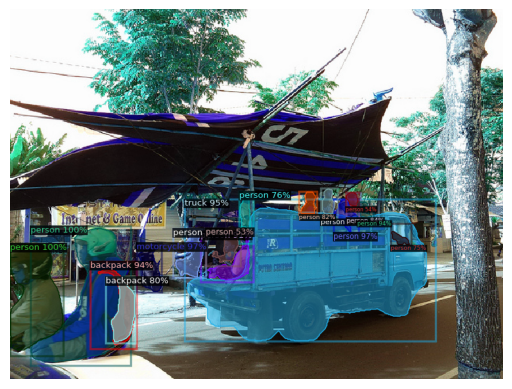

In [20]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# tf.keras.utils.array_to_img(out.get_image()[:, :, ::-1]).show()
plt.imshow(out.get_image()[:, :, ::-1]).set_cmap('hot')
plt.axis('off')


(-0.5, 67.5, 144.5, -0.5)

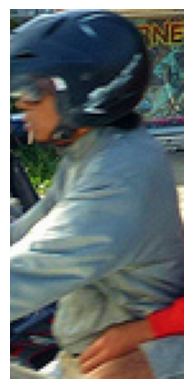

In [60]:
test = box_coordinates[1]
x = test[0]
y = test[1]
x_h = test[2]
y_h = test[3]
# np.flip to convert from BGR to RGB
plt.imshow(np.flip(cv2.imread(image_paths[0])[y:y_h, x:x_h], axis=-1))
plt.axis('off')

(-0.5, 42.5, 62.5, -0.5)

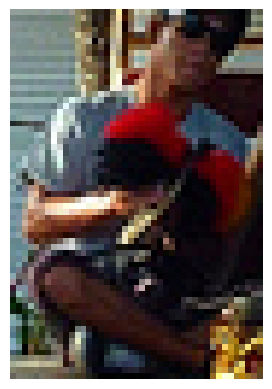

In [53]:
test = box_coordinates[4]
x = test[0]
y = test[1]
x_h = test[2]
y_h = test[3]
# np.flip to convert from BGR to RGB
plt.imshow(np.flip(cv2.imread(image_paths[0])[y:y_h, x:x_h], axis=-1))
plt.axis('off')

In [63]:
# load the instance segments on the subset_data
instance_boxes = json.load(
    open('../models/images/instance_segment_bb_subset.json'))


In [64]:
# https://codereview.stackexchange.com/questions/31352/overlapping-rectangles
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y


class Rect(object):
    def __init__(self, p1, p2):
        '''Store the top, bottom, left and right values for points 
               p1 and p2 are the (corners) in either order
        '''
        self.left = min(p1.x, p2.x)
        self.right = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top = max(p1.y, p2.y)

    @staticmethod
    def overlap(r1, r2):
        '''Overlapping rectangles overlap both horizontally & vertically
        '''
        h_overlaps = (r1.left <= r2.right) and (r1.right >= r2.left)
        v_overlaps = (r1.bottom <= r2.top) and (r1.top >= r2.bottom)
        return h_overlaps and v_overlaps

In [65]:
edge_list = []
for image_instances in tqdm(instance_boxes):  # n segments for each image
    interactions = []
    # apparently there are some images with no instance segments
    if len(image_instances) != 0:
        # initialize with the first interaction as a list
        interactions_list = [image_instances[0]]
    for instance in image_instances[1:]:  # n-1 interactions for each image
        for each_interaction in interactions_list:
            # check if the current interaction overlaps with any of the previous interactions
            # note that the order of the coordinates from the list are y:y_height, x:x_width
            l1 = Point(instance[2], instance[0])
            r1 = Point(instance[3], instance[1])
            l2 = Point(each_interaction[2], each_interaction[0])
            r2 = Point(each_interaction[3], each_interaction[1])
            # if it does, add an edge between the two where edge index is based on its position in the image_instances list
            if Rect.overlap(Rect(l1, r1), Rect(l2, r2)):
                interactions.append([image_instances.index(
                    each_interaction), image_instances.index(instance)])
            # print("Checking between", [image_instances.index(each_interaction), image_instances.index(instance)])
        # append the current interaction to the interactions_list
        interactions_list.append(instance)
    edge_list.append(interactions)


100%|██████████| 1233/1233 [00:00<00:00, 3918.52it/s]


In [67]:
edge_list[0]

[[0, 1],
 [2, 5],
 [4, 5],
 [2, 6],
 [5, 6],
 [0, 7],
 [3, 7],
 [2, 8],
 [5, 8],
 [4, 9],
 [5, 9],
 [2, 10],
 [5, 10],
 [6, 10],
 [5, 11],
 [0, 12],
 [7, 12],
 [5, 13],
 [9, 13],
 [5, 14],
 [2, 15],
 [5, 15],
 [6, 15],
 [10, 15],
 [4, 16],
 [5, 16],
 [9, 16],
 [13, 16]]

In [61]:
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Rect(object):
    def __init__(self, p1, p2):
        '''Store the top, bottom, left and right values for points 
               p1 and p2 are the (corners) in either order
        '''
        self.left = min(p1.x, p2.x)
        self.right = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top = max(p1.y, p2.y)

    @staticmethod
    def overlap(r1, r2):
        '''Overlapping rectangles overlap both horizontally & vertically
        '''
        h_overlaps = (r1.left <= r2.right) and (r1.right >= r2.left)
        v_overlaps = (r1.bottom <= r2.top) and (r1.top >= r2.bottom)
        return h_overlaps and v_overlaps

p1 = Point(1,1)
p2 = Point(3,3)
r1 = Rect(p1,p2)
p3 = Point(2,2)
p4 = Point(4,4)
r2 = Rect(p3,p4)

print("r1 (red),r2 (aqua): Overlap in either direction:")
print(Rect.overlap(r1,r2))
print(Rect.overlap(r2,r1))


p5 = Point(3,6)     # overlaps horizontally but not vertically
p6 = Point(12,11)
r3 = Rect(p5,p6)

print("r1 (red),r3 (blue): Should not overlap, either way:")
print(Rect.overlap(r1,r3))
print(Rect.overlap(r3,r1))

print("r2 (aqua),r3 (blue: Same as that")
print(Rect.overlap(r2,r3))
print(Rect.overlap(r3,r2))

p7 = Point(7,7)
p8 = Point(11,10)
r4 = Rect(p7,p8)    # completely inside r3

print("r4 (fuschia) is totally enclosed in r3 (blue)")
print(Rect.overlap(r3,r4))
print(Rect.overlap(r4,r3))

print("r4 (fuschia) is nowhere near r1 (red) nor r2 (aqua)")
print(Rect.overlap(r1,r4))

p09 = Point(13,11)
p10 = Point(19,13)
r5  = Rect(p09,p10)

p11 = Point(13,9)
p12 = Point(15,14)
r6  = Rect(p11,p12)

print("r5 (green) and r6 (yellow) cross without corner overlap")
print(Rect.overlap(r5,r6))
print(Rect.overlap(r6,r5))

l1 = Point(-0.5, 129.5) 
r1 = Point(180.5, -0.5)
rec1 = Rect(l1, r1)

l2 = Point(-0.5, 67.5)
r2 = Point(144.5, -0.5)
rec2 = Rect(l2, r2)
print(Rect.overlap(rec1, rec2))
print(Rect.overlap(rec2, rec1))



r1 (red),r2 (aqua): Overlap in either direction:
True
True
r1 (red),r3 (blue): Should not overlap, either way:
False
False
r2 (aqua),r3 (blue: Same as that
False
False
r4 (fuschia) is totally enclosed in r3 (blue)
True
True
r4 (fuschia) is nowhere near r1 (red) nor r2 (aqua)
False
r5 (green) and r6 (yellow) cross without corner overlap
True
True
True
True
